In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import os
from datetime import datetime
import warnings
import zipfile
import time
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
    
%matplotlib inline

warnings.filterwarnings('ignore')
np.random.seed(42)

### Setup

In [89]:
def create_project_structure():
    directories = ['data', 'models', 'results', 'notebooks', 'figures']
    
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")
    
    print("Project structure setup complete.")

### Querying

In [90]:
def fetch_kaggle_data(dataset_name="nathanlauga/nba-games", path="data/"):
    if not os.path.exists(path):
        os.makedirs(path)
    try:
        os.system(f"kaggle datasets download -d {dataset_name} -p {path}")
        print(f"Dataset downloaded to {path}")
        
        for file in os.listdir(path):
            if file.endswith('.zip'):
                with zipfile.ZipFile(os.path.join(path, file), 'r') as zip_ref:
                    zip_ref.extractall(path)
                os.remove(os.path.join(path, file))
                print(f"Extracted and removed {file}")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Kaggle API credentials")

def scrape_nba_player_stats(start_year=2004, end_year=2024, save_path="data/"):
    all_stats = []
    
    for year in range(start_year, end_year + 1):
        try:
            url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"
            response = requests.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')
            
            table = soup.find('table', id='per_game_stats')
            
            if table:
                # Convert to dataframe
                df = pd.read_html(str(table))[0]
                # Clean dataframe
                df = df[df['Rk'] != 'Rk'] 
                df['Season'] = f"{year-1}-{year}"
                
                all_stats.append(df)
                
                time.sleep(2)
            
        except Exception as e:
            print(f"Error scraping data for {year}: {e}")
    
    if all_stats:
        # Combine all seasons
        player_stats = pd.concat(all_stats, ignore_index=True)
        
        # Save to CSV
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            file_path = os.path.join(save_path, "player_stats.csv")
            player_stats.to_csv(file_path, index=False)
            print(f"Saved player stats to {file_path}")
        
        return player_stats
    else:
        print("No data collected.")
        return None

def load_nba_data(data_path="data/"):
    data_files = {
        'games': 'games.csv',
        'games_details': 'games_details.csv',
        'players': 'players.csv',
        'ranking': 'ranking.csv',
        'teams': 'teams.csv'
    }
    
    data = {}
    
    for key, filename in data_files.items():
        file_path = os.path.join(data_path, filename)
        if os.path.exists(file_path):
            data[key] = pd.read_csv(file_path)
            print(f"Loaded {key} data: {data[key].shape} rows x columns")
        else:
            print(f"Warning: {filename} not found in {data_path}")
    
    return data

def initial_data_analysis(data_dict):
    for name, df in data_dict.items():
        print(f"\n=== {name.upper()} Dataset ===")
        print(f"Shape: {df.shape}")
        print("\nColumns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
        
        print("\nMissing values:")
        missing = df.isnull().sum()
        for col, count in missing[missing > 0].items():
            print(f"  - {col}: {count} ({count/len(df):.2%})")
        
        print("\nSample data:")
        print(df.head(3))
        
        print("\n" + "="*50)


### Data Standardization

In [91]:
def standardize_data_formats(data_dict):
    standardized_data = {}
    
    for name, df in data_dict.items():
        std_df = df.copy()
        
        date_cols = [col for col in std_df.columns if 'DATE' in col or 'date' in col]
        for col in date_cols:
            try:
                std_df[col] = pd.to_datetime(std_df[col])
                print(f"Converted {col} to datetime in {name} dataset")
            except:
                print(f"Warning: Could not convert {col} to datetime in {name} dataset")
        
        pct_cols = [col for col in std_df.columns if 'PCT' in col or 'pct' in col or 'Percentage' in col]
        for col in pct_cols:
            if std_df[col].dtype == 'object':
                try:
                    std_df[col] = std_df[col].str.replace('%', '').astype(float) / 100
                    print(f"Converted {col} to float (0-1 range) in {name} dataset")
                except:
                    print(f"Warning: Could not convert {col} to float in {name} dataset")
        
        numeric_cols = std_df.select_dtypes(include=['int64']).columns
        for col in numeric_cols:
            std_df[col] = std_df[col].astype(float)
        
        standardized_data[name] = std_df
    
    return standardized_data

### ETL pipeline

In [92]:
def clean_initial_data(df):
    leaky_cols = [
        'PTS_home', 'PTS_away',
        'assist_efficiency_home', 'assist_efficiency_away', 'assist_efficiency_diff',
        'home_win', 'POINT_DIFF', 'ABS_POINT_DIFF'
    ]
    return df.drop(columns=[col for col in leaky_cols if col in df.columns], errors='ignore')

def filter_data_by_year(data_dict, start_year=2004):
    filtered_data = {}
    
    for name, df in data_dict.items():
        date_cols = [col for col in df.columns if 'DATE' in col or 'date' in col]
        
        if date_cols:
            date_col = date_cols[0]
            if not pd.api.types.is_datetime64_dtype(df[date_col]):
                df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            
            filtered_df = df[df[date_col].dt.year >= start_year].copy()
            print(f"Filtered {name} dataset: {len(df)} → {len(filtered_df)} records (after {start_year})")
            filtered_data[name] = filtered_df
        else:
            filtered_data[name] = df
            print(f"No date column found in {name} dataset, keeping all records")
    
    return filtered_data

def build_etl_pipeline(input_path="data/", output_path="data/processed/"):
    print("Step 1: Loading data")
    data = load_nba_data(input_path)
    
    print("\nStep 2: Initial data analysis")
    initial_data_analysis(data)
    
    print("\nStep 3: Standardizing data formats")
    standardized_data = standardize_data_formats(data)
    
    print("\nStep 4: Filtering data by year")
    filtered_data = filter_data_by_year(standardized_data, start_year=2004)
    
    print("\nStep 5: Handling missing values")
    processed_data = {}
    
    for name, df in filtered_data.items():
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if pd.api.types.is_numeric_dtype(df[col]):
                    df[col] = df[col].fillna(df[col].mean())
                    print(f"Filled missing values in {col} with mean in {name} dataset")
                else:
                    df[col] = df[col].fillna('Unknown')
                    print(f"Filled missing values in {col} with 'Unknown' in {name} dataset")
        
        processed_data[name] = df
    
    print("\nStep 6: Removing duplicates")
    for name, df in processed_data.items():
        if name == 'games':
            key_col = 'GAME_ID'
        elif name == 'games_details':
            key_col = ['GAME_ID', 'PLAYER_ID']
        elif name == 'players':
            key_col = 'PLAYER_ID'
        elif name == 'teams':
            key_col = 'TEAM_ID'
        elif name == 'ranking':
            key_col = ['TEAM_ID', 'STANDINGSDATE']
        else:
            key_col = df.columns.tolist()
        
        old_len = len(df)
        df = df.drop_duplicates(subset=key_col)
        new_len = len(df)
        
        if old_len != new_len:
            print(f"Removed {old_len - new_len} duplicates from {name} dataset")
        
        processed_data[name] = df
    
    print("\nStep 7: Saving processed data")
    os.makedirs(output_path, exist_ok=True)
    
    for name, df in processed_data.items():
        output_file = os.path.join(output_path, f"{name}_processed.csv")
        df.to_csv(output_file, index=False)
        print(f"Saved processed {name} data to {output_file}")
    
    return processed_data


### Feature Analysis

In [93]:
def calculate_team_metrics(games_df, teams_df, output_path="data/processed/"):
    games_df = games_df.sort_values('GAME_DATE_EST')
    team_metrics = pd.DataFrame()
    team_ids = teams_df['TEAM_ID'].unique()
    
    for team_id in team_ids:
        team_name = teams_df[teams_df['TEAM_ID'] == team_id]['NICKNAME'].iloc[0]
        print(f"Calculating metrics for {team_name}...")
        
        home_games = games_df[games_df['HOME_TEAM_ID'] == team_id]
        away_games = games_df[games_df['VISITOR_TEAM_ID'] == team_id]
        
        home_wins = home_games['HOME_TEAM_WINS'].sum()
        home_losses = len(home_games) - home_wins
        away_wins = len(away_games) - away_games['HOME_TEAM_WINS'].sum()
        away_losses = len(away_games) - away_wins
        
        total_wins = home_wins + away_wins
        total_losses = home_losses + away_losses
        win_pct = total_wins / (total_wins + total_losses) if (total_wins + total_losses) > 0 else 0
        
        home_pts_scored = home_games['PTS_home'].mean()
        home_pts_conceded = home_games['PTS_away'].mean()
        away_pts_scored = away_games['PTS_away'].mean()
        away_pts_conceded = away_games['PTS_home'].mean()
        
        avg_pts_scored = (home_pts_scored * len(home_games) + away_pts_scored * len(away_games)) / (len(home_games) + len(away_games)) if (len(home_games) + len(away_games)) > 0 else 0
        avg_pts_conceded = (home_pts_conceded * len(home_games) + away_pts_conceded * len(away_games)) / (len(home_games) + len(away_games)) if (len(home_games) + len(away_games)) > 0 else 0
        
        if 'FG_PCT_HOME' in home_games.columns and 'FG_PCT_AWAY' in away_games.columns:
            home_fg_pct = home_games['FG_PCT_HOME'].mean()
            away_fg_pct = away_games['FG_PCT_AWAY'].mean()
            avg_fg_pct = (home_fg_pct * len(home_games) + away_fg_pct * len(away_games)) / (len(home_games) + len(away_games)) if (len(home_games) + len(away_games)) > 0 else 0
        else:
            avg_fg_pct = None
        
        win_streak = 0
        loss_streak = 0
        current_streak = 0
        
        team_metrics = pd.concat([team_metrics, pd.DataFrame({
            'TEAM_ID': [team_id],
            'TEAM_NAME': [team_name],
            'TOTAL_GAMES': [total_wins + total_losses],
            'WINS': [total_wins],
            'LOSSES': [total_losses],
            'WIN_PCT': [win_pct],
            'HOME_WINS': [home_wins],
            'HOME_LOSSES': [home_losses],
            'AWAY_WINS': [away_wins],
            'AWAY_LOSSES': [away_losses],
            'AVG_PTS_SCORED': [avg_pts_scored],
            'AVG_PTS_CONCEDED': [avg_pts_conceded],
            'AVG_FG_PCT': [avg_fg_pct],
            'MAX_WIN_STREAK': [win_streak],
            'MAX_LOSS_STREAK': [loss_streak]
        })], ignore_index=True)
    
    if output_path:
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, "team_metrics.csv")
        team_metrics.to_csv(output_file, index=False)
        print(f"Saved team metrics to {output_file}")
    
    return team_metrics

def calculate_rolling_metrics(games_df, window_size=10, output_path="data/processed/"):
    games = games_df.copy()
    
    games = games.sort_values('GAME_DATE_EST')
    
    games['GAME_INDEX'] = range(len(games))
    
    rolling_cols = [
        'HOME_LAST_N_WIN_PCT', 'AWAY_LAST_N_WIN_PCT',
        'HOME_LAST_N_AVG_PTS', 'AWAY_LAST_N_AVG_PTS',
        'HOME_LAST_N_AVG_PTS_ALLOWED', 'AWAY_LAST_N_AVG_PTS_ALLOWED'
    ]
    
    for col in rolling_cols:
        games[col] = np.nan
    
    team_recent_games = {}

    for idx, row in games.iterrows():
        home_team_id = row['HOME_TEAM_ID']
        away_team_id = row['VISITOR_TEAM_ID']

        if home_team_id not in team_recent_games:
            team_recent_games[home_team_id] = []
        if away_team_id not in team_recent_games:
            team_recent_games[away_team_id] = []

        if len(team_recent_games[home_team_id]) > 0:
            last_n = team_recent_games[home_team_id][-window_size:]

            wins = sum(1 for g in last_n if 
                      (g['is_home'] and g['HOME_TEAM_WINS'] == 1) or 
                      (not g['is_home'] and g['HOME_TEAM_WINS'] == 0))
            games.at[idx, 'HOME_LAST_N_WIN_PCT'] = wins / len(last_n)

            pts_scored = [g['PTS_home'] if g['is_home'] else g['PTS_away'] for g in last_n]
            games.at[idx, 'HOME_LAST_N_AVG_PTS'] = sum(pts_scored) / len(pts_scored)

            pts_allowed = [g['PTS_away'] if g['is_home'] else g['PTS_home'] for g in last_n]
            games.at[idx, 'HOME_LAST_N_AVG_PTS_ALLOWED'] = sum(pts_allowed) / len(pts_allowed)

        if len(team_recent_games[away_team_id]) > 0:
            last_n = team_recent_games[away_team_id][-window_size:]

            wins = sum(1 for g in last_n if 
                      (g['is_home'] and g['HOME_TEAM_WINS'] == 1) or 
                      (not g['is_home'] and g['HOME_TEAM_WINS'] == 0))
            games.at[idx, 'AWAY_LAST_N_WIN_PCT'] = wins / len(last_n)
            

            pts_scored = [g['PTS_home'] if g['is_home'] else g['PTS_away'] for g in last_n]
            games.at[idx, 'AWAY_LAST_N_AVG_PTS'] = sum(pts_scored) / len(pts_scored)
            
            pts_allowed = [g['PTS_away'] if g['is_home'] else g['PTS_home'] for g in last_n]
            games.at[idx, 'AWAY_LAST_N_AVG_PTS_ALLOWED'] = sum(pts_allowed) / len(pts_allowed)
        
        home_game_data = {
            'GAME_ID': row['GAME_ID'],
            'is_home': True,
            'HOME_TEAM_WINS': row['HOME_TEAM_WINS'],
            'PTS_home': row['PTS_home'],
            'PTS_away': row['PTS_away']
        }
        team_recent_games[home_team_id].append(home_game_data)
        
        away_game_data = {
            'GAME_ID': row['GAME_ID'],
            'is_home': False,
            'HOME_TEAM_WINS': row['HOME_TEAM_WINS'],
            'PTS_home': row['PTS_home'],
            'PTS_away': row['PTS_away']
        }
        team_recent_games[away_team_id].append(away_game_data)
    
    games['HOME_LAST_N_WIN_PCT'] = games['HOME_LAST_N_WIN_PCT'].fillna(0.5)
    games['AWAY_LAST_N_WIN_PCT'] = games['AWAY_LAST_N_WIN_PCT'].fillna(0.5)
    
    avg_pts = games['PTS_home'].mean()
    games['HOME_LAST_N_AVG_PTS'] = games['HOME_LAST_N_AVG_PTS'].fillna(avg_pts)
    games['AWAY_LAST_N_AVG_PTS'] = games['AWAY_LAST_N_AVG_PTS'].fillna(avg_pts)
    
    games['HOME_LAST_N_AVG_PTS_ALLOWED'] = games['HOME_LAST_N_AVG_PTS_ALLOWED'].fillna(avg_pts)
    games['AWAY_LAST_N_AVG_PTS_ALLOWED'] = games['AWAY_LAST_N_AVG_PTS_ALLOWED'].fillna(avg_pts)

    if output_path:
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, "games_with_rolling_metrics.csv")
        games.to_csv(output_file, index=False)
        print(f"Saved games with rolling metrics to {output_file}")
    
    return games

In [96]:
def create_feature_dataset(games_df, game_details_df=None, team_metrics_df=None, player_stats_df=None, output_path="data/processed/"):
    features = games_df.copy()
    if team_metrics_df is not None:
        features = pd.merge(
            features,
            team_metrics_df,
            left_on='HOME_TEAM_ID',
            right_on='TEAM_ID',
            how='left',
            suffixes=('', '_HOME')
        )
        
        features = pd.merge(
            features,
            team_metrics_df,
            left_on='VISITOR_TEAM_ID',
            right_on='TEAM_ID',
            how='left',
            suffixes=('_HOME', '_AWAY')
        )
        
        cols_to_drop = [col for col in features.columns if col.endswith('_HOME_AWAY')]
        features = features.drop(columns=cols_to_drop, errors='ignore')
    
    if game_details_df is not None and player_stats_df is not None:
        pass
    
    features['SEASON'] = features['GAME_DATE_EST'].dt.year
    features['MONTH'] = features['GAME_DATE_EST'].dt.month
    features['DAY_OF_WEEK'] = features['GAME_DATE_EST'].dt.dayofweek
    
    if 'SEASON_TYPE' in features.columns:
        features['IS_PLAYOFFS'] = features['SEASON_TYPE'].apply(lambda x: 1 if 'Playoffs' in x else 0)
    else:
        print("Assuming all games are regular season")
        features['IS_PLAYOFFS'] = 0

    features['HOME_COURT_ADVANTAGE'] = 1 
    if 'PTS_home' not in features.columns:
        print("Warning: PTS_home not found in features, cannot set target variable")
    if 'PTS_away' not in features.columns:
        print("Warning: PTS_away not found in features, cannot set target variable")

    cols_to_drop = ['TEAM_ID_HOME', 'TEAM_ID_AWAY', 'GAME_STATUS_TEXT']
    features = features.drop(columns=[col for col in cols_to_drop if col in features.columns])
    leakage_cols = [
    'PTS_home', 'PTS_away',
    'assist_efficiency_home', 'assist_efficiency_away', 'assist_efficiency_diff',
    'home_win', 'POINT_DIFF', 'ABS_POINT_DIFF'
]


    if output_path:
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, "final_feature_dataset.csv")
        features = features.drop(columns=[col for col in leakage_cols if col in features.columns])
        features.to_csv(output_file, index=False)
        print(f"Saved final feature dataset to {output_file}")
    
    return features
    
def visualize_feature_distributions(features_df, output_path="figures/"):
    os.makedirs(output_path, exist_ok=True)

    num_cols = features_df.select_dtypes(include=['int64', 'float64']).columns

    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    fig_width = n_cols * 5
    fig_height = n_rows * 3

    plt.figure(figsize=(fig_width, fig_height))

    for i, col in enumerate(num_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        try:
            if features_df[col].nunique() > 5:
                sns.histplot(features_df[col], kde=True)
            else:
                sns.countplot(x=features_df[col], data=features_df)

            plt.title(f'Distribution of {col}')
        except Exception as e:
            plt.title(f"Error plotting {col}")
        plt.tight_layout()

    plt.savefig(os.path.join(output_path, 'feature_distributions.png'))
    plt.show()

    if 'PTS_home' in features_df.columns or 'PTS_away' in features_df.columns:
        plt.figure(figsize=(12, 5))

        if 'PTS_home' in features_df.columns:
            plt.subplot(1, 2, 1)
            sns.histplot(features_df['PTS_home'], kde=True)
            plt.title('Distribution of Home Team Points')

        if 'PTS_away' in features_df.columns:
            plt.subplot(1, 2, 2)
            sns.histplot(features_df['PTS_away'], kde=True)
            plt.title('Distribution of Away Team Points')

        plt.tight_layout()
        plt.savefig(os.path.join(output_path, 'target_distributions.png'))
        plt.show()

    print(f"Saved visualizations to {output_path}")

def analyze_feature_importance(features_df, target_cols=['PTS_home', 'PTS_away'], output_path="figures/"):
    os.makedirs(output_path, exist_ok=True)

    numeric_df = features_df.select_dtypes(include=['int64', 'float64'])
    
    for target in target_cols:
        if target in numeric_df.columns:
            corr_with_target = numeric_df.drop(columns=target_cols).corrwith(numeric_df[target])
            corr_with_target = corr_with_target.abs().sort_values(ascending=False)
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x=corr_with_target.values[:15], y=corr_with_target.index[:15])
            plt.title(f'Features with Highest Correlation to {target}')
            plt.xlabel('Absolute Correlation')
            plt.tight_layout()
            plt.savefig(os.path.join(output_path, f'feature_importance_{target}.png'))
            plt.show()

            corr_df = pd.DataFrame({
                'Feature': corr_with_target.index,
                'Correlation': corr_with_target.values
            })
            corr_df.to_csv(os.path.join(output_path, f'feature_correlation_{target}.csv'), index=False)
            
            print(f"Saved feature importance analysis for {target} to {output_path}")
        else:
            print(f"Warning: Target column {target} not found in numeric features")

def analyze_win_prediction_features(features_df, home_pts_col='PTS_home', away_pts_col='PTS_away', 
                                   output_path="figures/", 
                                   min_target_corr=0.05,
                                   max_feature_corr=0.8):
    os.makedirs(output_path, exist_ok=True)
    
    df = features_df.copy()
    
    if 'HOME_TEAM_WINS' in df.columns:
        df['home_win'] = df['HOME_TEAM_WINS']
    else:
        df['home_win'] = (df[home_pts_col] > df[away_pts_col]).astype(int)

        df['point_diff'] = df[home_pts_col] - df[away_pts_col]
    
    features_to_remove = ['HOME_TEAM_WINS', 'POINT_DIFF', 'ABS_POINT_DIFF']

    exclude_cols = [home_pts_col, away_pts_col, 'home_win', 'point_diff']
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    X = numeric_df.drop(columns=[col for col in exclude_cols if col in numeric_df.columns])
    X = X.drop(columns=[col for col in features_to_remove if col in X.columns])
    y = df['home_win']
    
    print(f"Analyzing features for predicting home team wins")
    print(f"Home win rate: {y.mean()*100:.2f}%")
    print(f"Number of features: {X.shape[1]}")
    
    corr_with_target = X.corrwith(y).abs()
    
    plt.figure(figsize=(12, 10))
    sorted_corr = corr_with_target.sort_values(ascending=False)
    top_features = sorted_corr.head(20)
    
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top 20 Features Correlated with Home Team Win')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'feature_importance_win_corr.png'))
    plt.close()
    
    high_corr_features = corr_with_target[corr_with_target >= min_target_corr].index.tolist()
    X_filtered = X[high_corr_features]
    
    removed_features = set(X.columns) - set(high_corr_features)
    print(f"Removed {len(removed_features)} features with correlation < {min_target_corr}")
    
    if len(high_corr_features) > 1:
        corr_matrix = X_filtered.corr().abs()

        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = set()

        for i, feature in enumerate(upper.columns):
            correlated_features = upper.index[upper[feature] > max_feature_corr]
            
            if len(correlated_features) > 0:
                correlated_group = [feature] + list(correlated_features)
                corr_to_target = {f: corr_with_target[f] for f in correlated_group}
                best_feature = max(corr_to_target, key=corr_to_target.get)

                to_drop.update([f for f in correlated_group if f != best_feature])

        if to_drop:
            print(f"Removed {len(to_drop)} features due to high correlation with other features")

            X_filtered = X_filtered.drop(columns=list(to_drop))

    try:
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_filtered, y)

        rf_importance = pd.DataFrame({
            'Feature': X_filtered.columns,
            'Importance': rf_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 10))
        sns.barplot(x='Importance', y='Feature', data=rf_importance)
        plt.title('Random Forest Feature Importance for Win Prediction')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, 'feature_importance_win_rf.png'))
        plt.close()

        result = permutation_importance(rf_model, X_filtered, y, n_repeats=10, random_state=42)
        
        perm_importance = pd.DataFrame({
            'Feature': X_filtered.columns,
            'Importance': result.importances_mean,
            'Std': result.importances_std
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 10))
        sns.barplot(x='Importance', y='Feature', data=perm_importance)
        plt.title('Permutation Feature Importance for Win Prediction')
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, 'feature_importance_win_perm.png'))
        plt.close()
        
        comprehensive_results = pd.DataFrame({
            'Feature': list(X.columns),
            'Correlation': [corr_with_target.get(col, 0) for col in X.columns],
            'Kept_After_Filtering': [col in X_filtered.columns for col in X.columns],
            'RF_Importance': [rf_importance.set_index('Feature').get('Importance', {}).get(col, 0) 
                             if col in X_filtered.columns else 0 for col in X.columns],
            'Perm_Importance': [perm_importance.set_index('Feature').get('Importance', {}).get(col, 0) 
                               if col in X_filtered.columns else 0 for col in X.columns]
        }).sort_values('Perm_Importance', ascending=False)
        
        comprehensive_results.to_csv(os.path.join(output_path, 'feature_importance_win_comprehensive.csv'), index=False)
    
    except Exception as e:
        print(f"Error in model-based feature importance: {e}")
        comprehensive_results = pd.DataFrame({
            'Feature': list(X.columns),
            'Correlation': [corr_with_target.get(col, 0) for col in X.columns],
            'Kept_After_Filtering': [col in X_filtered.columns for col in X.columns]
        }).sort_values('Correlation', ascending=False)
        
        comprehensive_results.to_csv(os.path.join(output_path, 'feature_importance_win_correlations.csv'), index=False)
    
    filtered_df = pd.concat([X_filtered, y], axis=1)
    
    print(f"Original features: {X.shape[1]}, Filtered features: {X_filtered.shape[1]}")
    print(f"Saved win prediction feature importance analysis to {output_path}")
    print("Features being used for prediction:")
    print(X.columns.tolist())
    
    return filtered_df


Project structure setup complete.

Loading NBA data...
Loaded games data: (26651, 21) rows x columns
Loaded games_details data: (668628, 29) rows x columns
Loaded players data: (7228, 4) rows x columns
Loaded ranking data: (210342, 13) rows x columns
Loaded teams data: (30, 14) rows x columns

Building and executing ETL pipeline
Step 1: Loading data
Loaded games data: (26651, 21) rows x columns
Loaded games_details data: (668628, 29) rows x columns
Loaded players data: (7228, 4) rows x columns
Loaded ranking data: (210342, 13) rows x columns
Loaded teams data: (30, 14) rows x columns

Step 2: Initial data analysis

=== GAMES Dataset ===
Shape: (26651, 21)

Columns:
  - GAME_DATE_EST (object)
  - GAME_ID (int64)
  - GAME_STATUS_TEXT (object)
  - HOME_TEAM_ID (int64)
  - VISITOR_TEAM_ID (int64)
  - SEASON (int64)
  - TEAM_ID_home (int64)
  - PTS_home (float64)
  - FG_PCT_home (float64)
  - FT_PCT_home (float64)
  - FG3_PCT_home (float64)
  - AST_home (float64)
  - REB_home (float64)
  - 

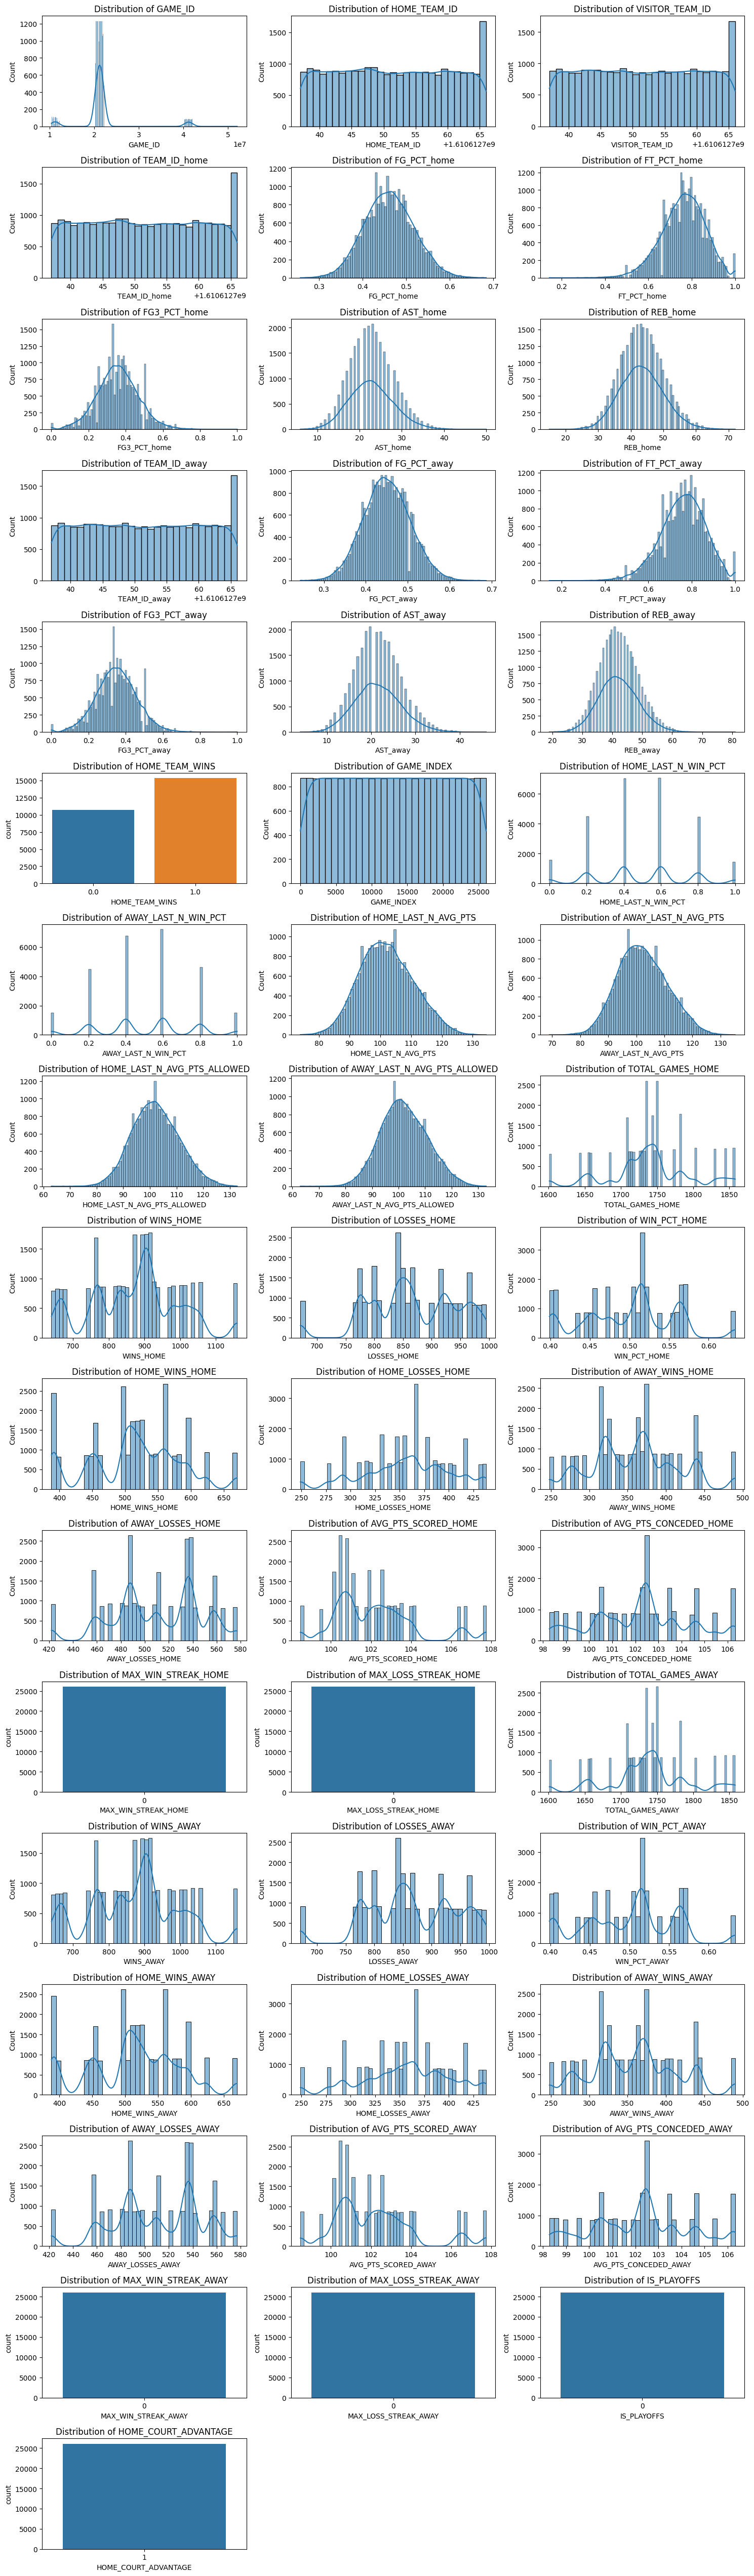

Saved visualizations to figures/

Analyzing feature importance...
Analyzing features for predicting home team wins
Home win rate: 58.85%
Number of features: 48
Removed 16 features with correlation < 0.05
Removed 14 features due to high correlation with other features
Original features: 48, Filtered features: 18
Saved win prediction feature importance analysis to figures/
Features being used for prediction:
['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'GAME_INDEX', 'HOME_LAST_N_WIN_PCT', 'AWAY_LAST_N_WIN_PCT', 'HOME_LAST_N_AVG_PTS', 'AWAY_LAST_N_AVG_PTS', 'HOME_LAST_N_AVG_PTS_ALLOWED', 'AWAY_LAST_N_AVG_PTS_ALLOWED', 'TOTAL_GAMES_HOME', 'WINS_HOME', 'LOSSES_HOME', 'WIN_PCT_HOME', 'HOME_WINS_HOME', 'HOME_LOSSES_HOME', 'AWAY_WINS_HOME', 'AWAY_LOSSES_HOME', 'AVG_PTS_SCORED_HOME', 'AVG_PTS_CONCEDED_HOME', 'MAX_WIN_STREAK

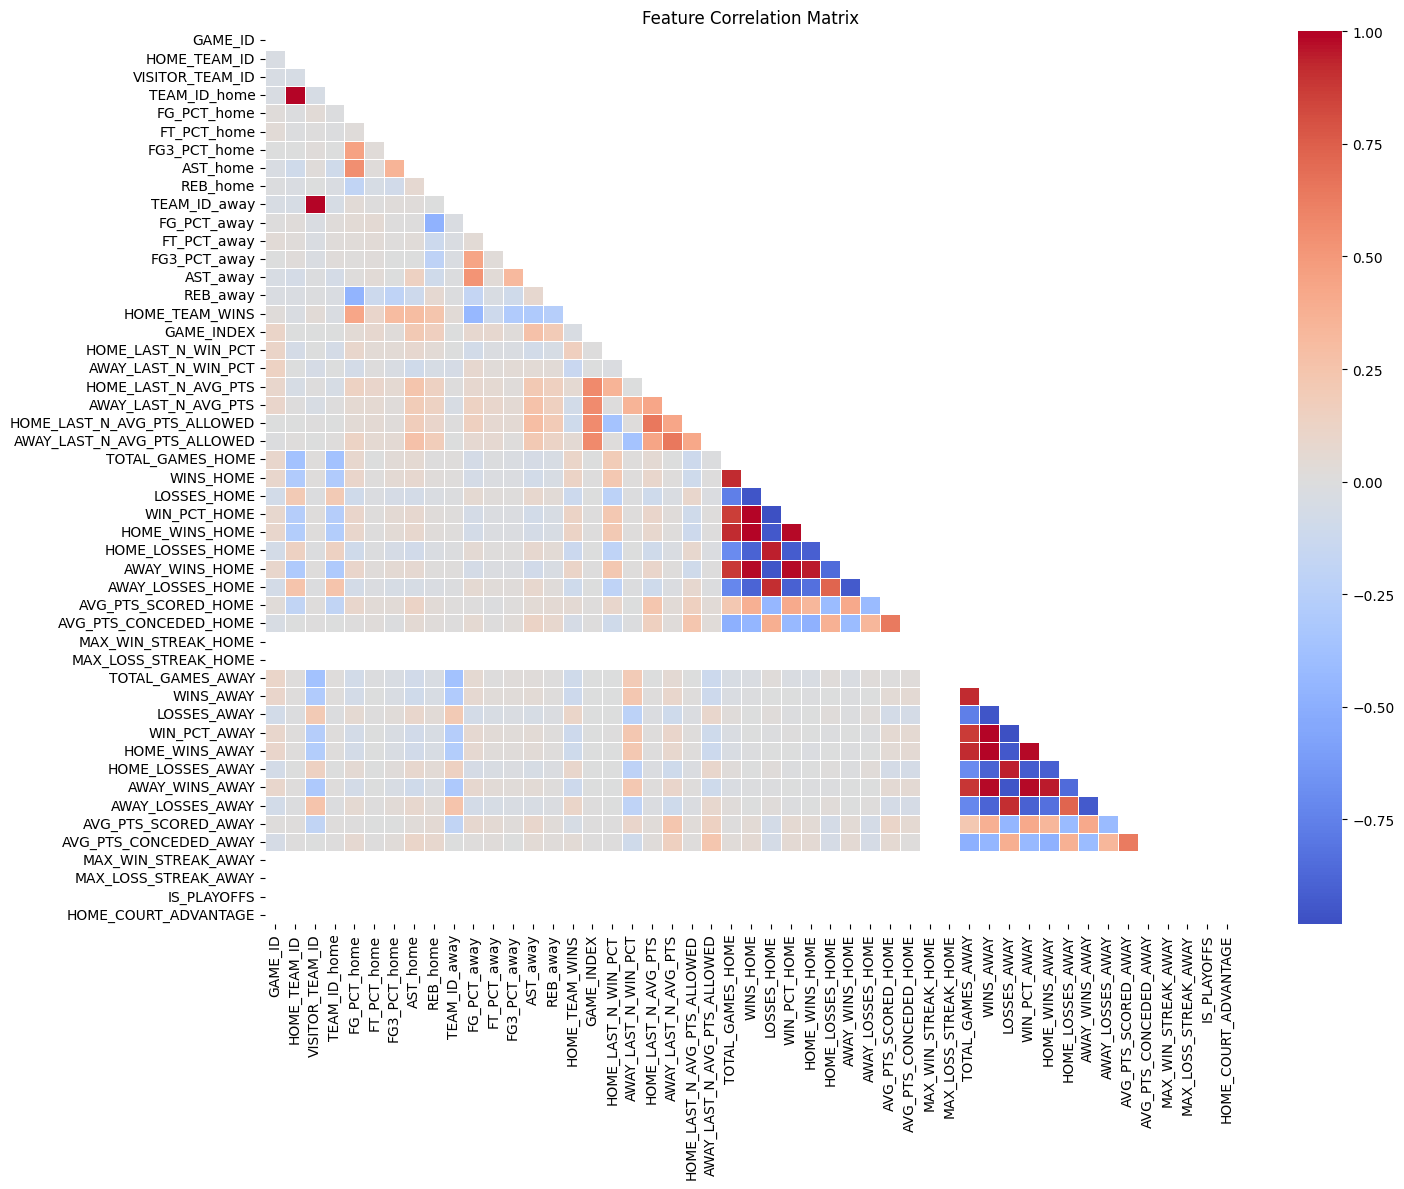

In [97]:
def run_weeks_1_2():
    create_project_structure()
    data_path = "data/"
    if not os.path.exists(os.path.join(data_path, "games.csv")):
        print("\nDownloading dataset from Kaggle")
        fetch_kaggle_data()

    print("\nLoading NBA data...")
    nba_data = load_nba_data(data_path)

    print("\nBuilding and executing ETL pipeline")
    processed_data = build_etl_pipeline(data_path, os.path.join(data_path, "processed/"))


    print("\nCalculating team performance metrics")
    team_metrics = calculate_team_metrics(
        processed_data['games'], 
        processed_data['teams'],
        os.path.join(data_path, "processed/")
    )
    
    print("\nCalculating rolling metrics")
    games_with_rolling = calculate_rolling_metrics(
        processed_data['games'],
        window_size=5,
        output_path=os.path.join(data_path, "processed/")
    )
    leakage_cols = [
        'PTS_home', 'PTS_away',
        'assist_efficiency_home', 'assist_efficiency_away', 'assist_efficiency_diff',
        'home_win', 'POINT_DIFF', 'ABS_POINT_DIFF'
    ]
    games_cleaned = games_with_rolling.drop(columns=[col for col in leakage_cols if col in games_with_rolling.columns])

    print("\nCreating final feature dataset")
    final_features = create_feature_dataset(
        games_cleaned,
        processed_data.get('games_details', None),
        team_metrics,
        None,
        os.path.join(data_path, "processed/")
    )
    
    print("\nVisualizing feature distributions")
    visualize_feature_distributions(final_features, "figures/")
    
    print("\nAnalyzing feature importance...")
    analyze_feature_importance(
    final_features,
    target_cols=['PTS_home', 'PTS_away'], 
    output_path="figures/"
    )

    filtered_data = analyze_win_prediction_features(
    final_features,
    home_pts_col='PTS_home',
    away_pts_col='PTS_away',
    min_target_corr=0.05,
    max_feature_corr=0.8
    )
    
    print("\n" + "=" * 30)
    print("=" * 30)
    print(f"\nProcessed data and visualizations saved to {os.path.abspath(data_path)}/processed/ and figures/")
    return final_features

if __name__ == "__main__":
    final_features = run_weeks_1_2()
    
    output_path = "figures/"
    num_cols = final_features.select_dtypes(include=['int64', 'float64']).columns
    
    plt.figure(figsize=(15, 12))
    corr_matrix = final_features[num_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'feature_correlation.png'))
    plt.show()
    plt.close()